<a href="https://colab.research.google.com/github/Abhishek-xavi/DataScienceProjects/blob/main/EDA_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connecting to Kaggle Dataset
!pip install kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install pandas --upgrade
!python -m spacy download en_core_web_sm

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
     |████████████████████████████████| 12.0 MB 14.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#Downloading the datset from Kaggle
!kaggle datasets download therohk/million-headlines

million-headlines.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Unzipping the Dataset
!unzip million-headlines.zip

Archive:  million-headlines.zip
replace abcnews-date-text.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: abcnews-date-text.csv   


In [ ]:
#Installing Libraries
!pip install \pandas matplot numpy \
  nltk seaborn sklearn gensim pyldavis \
  wordcloud textblob spacy textstat

In [ ]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import nltk
from nltk.util import ngrams
from collections import  Counter
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy

/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [ ]:
news= pd.read_csv('/content/abcnews-date-text.csv',nrows=10000)
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


# Statistical Analysis
We shall explore the first 10000 rows from 19th Feb to 7th April
First we will run a statistical analysis on the text. This will include,
*   Word frequency
*   Sentence length
*   Average word length

Here we will be using histograms(For continuous data) and bar charts(Categorical data)




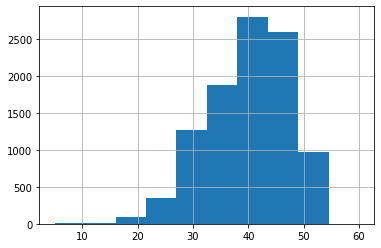

In [ ]:
#Number of characters in each headline
news['headline_text'].str.len().hist()

This chart tells us that we have upto 65 characters in a sentence. And on an average the sentences are 38-48 characters long.

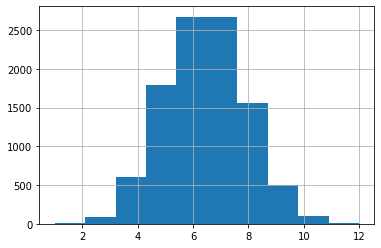

In [ ]:
#Exploring the number of words in each news headlines
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
plot_word_number_histogram(news['headline_text'])

From the above histogram we understand that there are roughly 3-10 words per headlines. With 6-8 words being average.

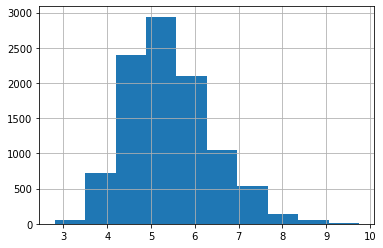

In [ ]:
#Explore the average word length in every headline.
news['headline_text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

We can observe that average word count varies from 3 to 6.
Lets understand further as to if there are stop words being used here like a, an , the, etc.
For this corpus of stopwords we need the nltk library.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

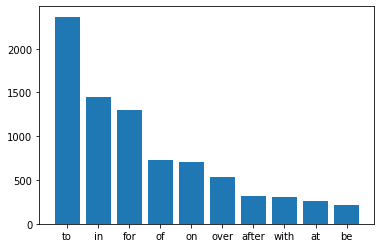

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
corpus = []
new = news['headline_text'].str.split()
new = new.values.tolist()
#Nested for loop. This is equivalent to - i in new: word in i: word.
#Basically new has every headline. We iterate over every headline with i and the iterate for every word in i
#with the variable word and use that variable. Now corpus has a list of words.
corpus = [word for i in new for word in i]

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top = sorted(dic.items(), key = lambda x:x[1], reverse=True)[:10]
x,y = zip(*top)
plt.bar(x,y)


We can observe news headlines have a lot of - 'to, in, for'.
Lets see which other non stopword, words top the list.

We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples. This is a very useful function when we deal with word-level analysis in natural language processing.

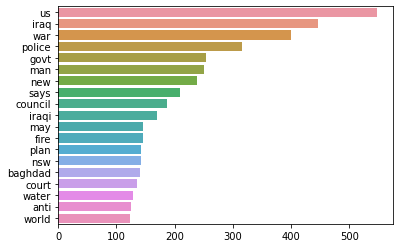

In [ ]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:40]:
  if (word not in stop):
    x.append(word)
    y.append(count)

sns.barplot(x=y, y=x)

During the feb to april in 2003 US, IRAQ and WAR were the most common words. us could be me and you 'us', but since we removed stop words, it must be US. This ends EDA from single words perspective. 

# NGRAM EXPLORATION

Ngrams are simply contiguous sequences of n words. For example “riverbank”,” The three musketeers” etc.If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

To implement n-grams we will use ngrams function from nltk.util.

To build a representation of our vocabulary we will use Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form. It is available in sklearn.feature_engineering.text

In [ ]:
def get_top_ngram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx])
                for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
  return words_freq[:10]

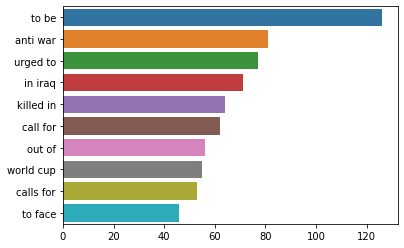

In [ ]:
top_n_bigrams = get_top_ngram(news['headline_text'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

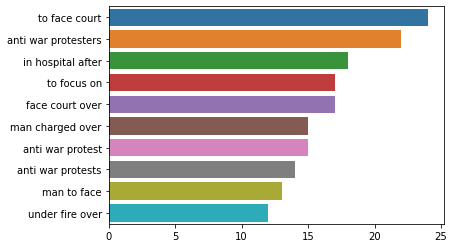

In [ ]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

We can see that many of these trigrams are some combinations of “to face court” and “anti war protest”. It means that we should put some effort into data cleaning and see if we were able to combine those synonym terms into one clean token.

# Topic modeling exploration with pyLDAvis

Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.

But before getting into topic modeling we have to pre-process our data a little. We will:

tokenize: the process by which sentences are converted to a list of tokens or words.
remove stopwords
lemmatize: reduces the inflectional forms of each word into a common base or root.
convert to the bag of words: Bag of words is a dictionary where the keys are words(or ngrams/tokens) and values are the number of times each word occurs in the corpus.

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
import nltk.tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#We have defined a fucntion for tokenizing, removing stop words and lemmatizing it(getting the root word)

def preprocess_news(df):
    corpus=[]
    #stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(news)

Creating a bag of words using gensim

# Gensim : 
It is an open source library in python written by Radim Rehurek which is used in unsupervised topic modelling and natural language processing. It is designed to extract semantic topics from documents. 

In [ ]:

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.029*"iraq" + 0.028*"war" + 0.008*"anti" + 0.008*"say" + 0.007*"govt" + 0.007*"sars" + 0.006*"iraqi" + 0.006*"troop" + 0.006*"protest" + 0.006*"fire"'),
 (1,
  '0.010*"baghdad" + 0.008*"iraqi" + 0.007*"win" + 0.007*"crash" + 0.006*"say" + 0.006*"plan" + 0.005*"new" + 0.005*"force" + 0.004*"police" + 0.004*"cup"'),
 (2,
  '0.009*"govt" + 0.007*"qld" + 0.006*"council" + 0.006*"water" + 0.005*"concern" + 0.005*"fund" + 0.005*"get" + 0.005*"nsw" + 0.004*"fire" + 0.004*"group"'),
 (3,
  '0.014*"man" + 0.013*"police" + 0.008*"new" + 0.007*"court" + 0.007*"council" + 0.007*"hit" + 0.006*"win" + 0.006*"charge" + 0.006*"charged" + 0.005*"face"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.056072  0.183805       1        1  26.886840
0      0.162894 -0.040531       2        1  26.358995
3     -0.151808 -0.118672       3        1  23.762240
1      0.044987 -0.024602       4        1  22.991925, topic_info=        Term        Freq       Total Category  logprob  loglift
49       war  373.000000  373.000000  Default  30.0000  30.0000
43      iraq  411.000000  411.000000  Default  29.0000  29.0000
317      man  206.000000  206.000000  Default  28.0000  28.0000
588     anti  107.000000  107.000000  Default  27.0000  27.0000
275   police  249.000000  249.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1337     two   31.642208   81.945196   Topic4  -5.9151   0.5185
79     troop   31.621073  122.250499   Topic4  -5.9158   0.1178
1735  saddam   28.786482   75.604748   Topic4  -6.0097   0.5044
422    claim   30.817462  145.548748   Topic4  -5.9415  -0.0824
11      call   29.477086  135.135551   Topic4  -5.9860  -0.0526

[282 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
372       1  0.966628  aboriginal
2400      3  0.932503       abuse
2400      4  0.058281       abuse
1084      3  0.981514    accident
5         1  0.890260         act
...     ...       ...         ...
488       3  0.341174       world
488       4  0.368109       world
1352      2  0.191350        year
1352      3  0.574050        year
1352      4  0.223242        year

[449 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

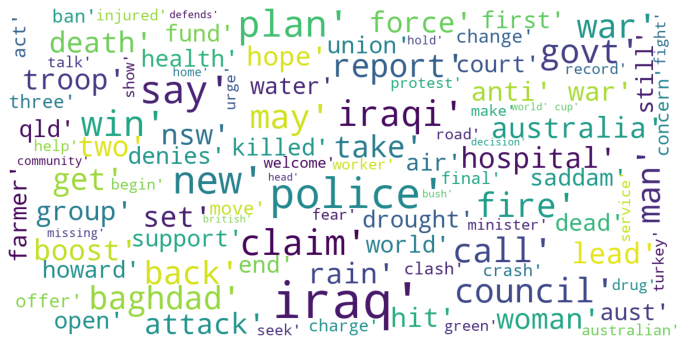

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

# Sentiment analysis

Sentiment analysis is a very common natural language processing task in which we determine if the text is positive, negative or neutral. 

# Textblob

Textblob is a python library built on top of nltk. 

The sentiment function of TextBlob returns two properties:

polarity: is a floating-point number that lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
subjectivity: refers to how someone’s judgment is shaped by personal opinions and feelings. Subjectivity is represented as a floating-point value which lies in the range of [0,1].

In [ ]:
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

TextBlob claims that the text “100 people killed in Iraq” is negative and is not an opinion or feeling but rather a factual statement.

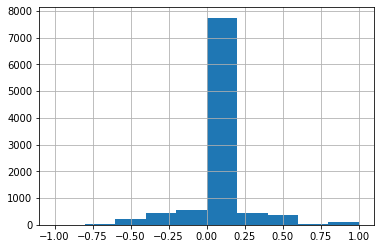

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['headline_text'].\
   apply(lambda x : polarity(x))
news['polarity_score'].hist()

Majority of the news seems to be neutral. Let classify this data further.

<BarContainer object of 3 artists>

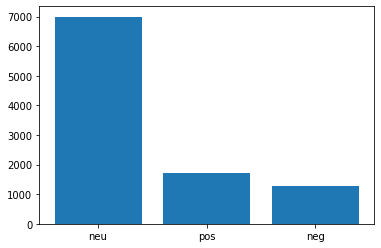

In [ ]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].\
   map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [ ]:
#This is great. MAjority if the news is positive.
#Lets look at a few positive and negative headlines.

news[news['polarity']=='pos']['headline_text'].head()


1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [ ]:
news[news['polarity']=='neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

# Vader sentiment analysis

The next library we are going to discuss is VADER. Vader works better in detecting negative sentiment. It is very useful in the case of social media text sentiment analysis.

VADER or Valence Aware Dictionary and Sentiment Reasoner is a rule/lexicon-based, open-source sentiment analyzer pre-built library, protected under the MIT license.

VADER sentiment analysis class returns a dictionary that contains the probabilities of the text for being positive, negative and neutral. Then we can filter and choose the sentiment with most probability.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

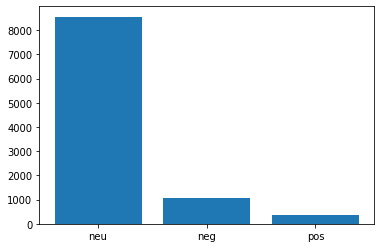

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    # The dictionary is something like this {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}
    ss = sid.polarity_scores(sent)
    #return ss
    #from the returned dictionary of scores we need only the max sentiment value. Hence we do np.argmax. Also since we 
    #do not want compound score, we slice the data by deleting the last entry with [:-1]
    return np.argmax(list(ss.values())[:-1]) 

news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

VADER gives us a much clearer idea  on the sentiment of the line. AS every word is evaluated and given a value and we take the maximum. We can see a lot more sentences are neutral and there is a difference between neg and pos sentiments as compared to TextBlob.

## Named entity recognition

Named entity recognition is an information extraction method in which entities that are present in the text are classified into predefined entity types like “Person”,” Place”,” Organization”, etc. By using NER we can get great insights about the types of entities present in the given text dataset.

There are three standard libraries to do Named Entity Recognition:

Standford NER
spaCy
NLTK
In this tutorial, I will use spaCy which is an open-source library for advanced natural language processing tasks. It is written in Cython and is known for its industrial applications. Besides NER, spaCy provides many other functionalities like pos tagging, word to vector transformation, etc.

There are three pre-trained models for English in spaCy. I will use en_core_web_sm for our task but you can try other models.

In [ ]:
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
#EXample to understand spacy
doc=nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


[('India', 'GPE'),
 ('Iran', 'GPE'),
 ('Chabahar', 'PERSON'),
 ('Thursday', 'DATE')]

In [ ]:
from spacy import displacy

displacy.render(doc, style='ent')

/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    India\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n and \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Iran\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">GPE</span>\n</mark>\n have agreed to boost the economic viability of the strategic \n<mark class="entity" style="background: #aa9cfc; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Chabahar\n    <span style="font-size: 0.8em; font-weight: bold; line-h

In [ ]:
#Using NAmed entity recognition to labels words
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['headline_text'].\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

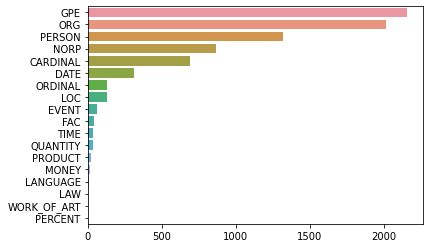

In [ ]:
#Visaually displaying named entity's frequencies.
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

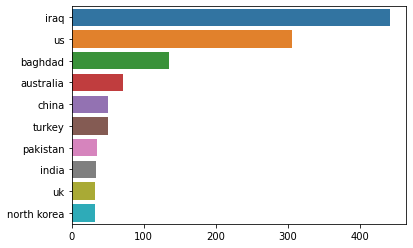

In [ ]:
def ner1(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=news['headline_text'].apply(lambda x: ner1(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

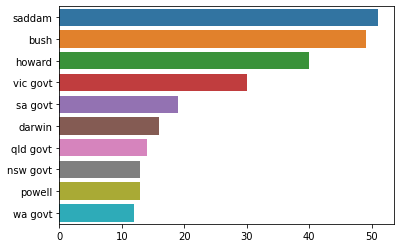

In [ ]:
per=news['headline_text'].apply(lambda x: ner1(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

## Exploring through text complexity

It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. Do we need a college degree to understand the message or a first-grader can clearly see what the point is?

You can actually put a number called readability index on a document or text. Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.

Textstat is a cool Python library that provides an implementation of all these text statistics calculation methods. Let’s use Textstat to implement Flesch Reading Ease index.

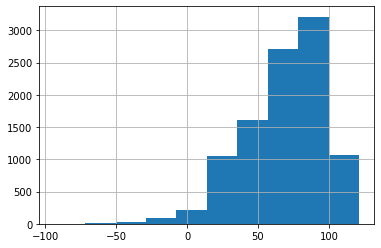

In [ ]:
from textstat import flesch_reading_ease

news['reading'] = news['headline_text'].\
   apply(lambda x : flesch_reading_ease(x))

news['headline_text'].\
   apply(lambda x : flesch_reading_ease(x)).hist()

In [ ]:
news.head()

,publish_date,headline_text,polarity_score,polarity,reading
0,20030219,aba decides against community broadcasting lic...,0.00,1,14.63
1,20030219,act fire witnesses must be aware of defamation,0.25,1,80.28
2,20030219,a g calls for infrastructure protection summit,0.00,1,38.99
3,20030219,air nz staff in aust strike for pay rise,0.00,1,113.10
4,20030219,air nz strike to affect australian travellers,0.00,1,81.29


Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5.

In [ ]:
x=[i for i in range(len(news)) if news['reading'][i]<5]
news.iloc[x]['headline_text'].head()

134    policewomen accusations feature at federal crime
150      report highlights container terminal potential
285       groups praise outgoing opposition agriculture
298            investigations underway into qantas skid
308      landholder contribution still under discussion
Name: headline_text, dtype: object

You can see some of the complex words being used in news headlines like “capitulation”,” interim”,” entrapment” etc. These words may have caused the scores to fall under 5.

Reference to this EDA - 
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools